In [75]:
from typing import Tuple, List
import requests
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [76]:
# You can skip understanding the following code. It's only here to get some data to work with.
def build_auto_insurance_dataset() -> Tuple[List[float], List[float]]:
    url='https://www.math.muni.cz/~kolacek/docs/frvs/M7222/data/AutoInsurSweden.txt'
    raw_dataset = requests.get(url)
    features, labels = [], []
    index_at_which_features_and_labels_start = 11

    raw_data = raw_dataset.text.split("\n")[index_at_which_features_and_labels_start:-1]
    for feature_and_label in raw_data:
        feature_and_label = feature_and_label.split("\t")
        features.append([float(feature_and_label[0].replace(",", "."))])
        labels.append(float(feature_and_label[1].replace(",", ".")))
    return jnp.array(features), jnp.array(labels).reshape(-1, 1)

class PlottingUtils:


    @staticmethod
    def plot_results(features: List[float], labels: List[float], predictions: List[float]):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(features, labels, 'bo', label='Real values')
        ax.plot(features, predictions, 'ro', label='Predicted values')
        ax.plot(features.reshape(-1), predictions.reshape(-1), label='Real values')
        ax.legend(["Actual", "Predicted"])
        ax.set_ylabel("Claims in thousands of Swedish kronor")
        ax.set_xlabel("Number of claims")
        # fig.ylabel("Claims in thousands of Swedish kronor")
        # fig.xlabel("Number of claims")
        return fig, ax


In [77]:
# features is equal to the total number of claims for a given year
# labels is the total payment for all claims in thousands of Swedish kronor
features, labels = build_auto_insurance_dataset()


The goal of this notebook is to help you get an understanding of how Deep Learning models work under the hood. 

In this notebook we will:
- Introduce the problem we'll solve with ML.
- getting familiar with notation
- Introduce JAX (INSERT LINK).
- define a forward pass through our model
- define a cost function
- create a backward pass to update the model



Our features has shape: (63, 1)


(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='Number of claims', ylabel='Claims in thousands of Swedish kronor'>)

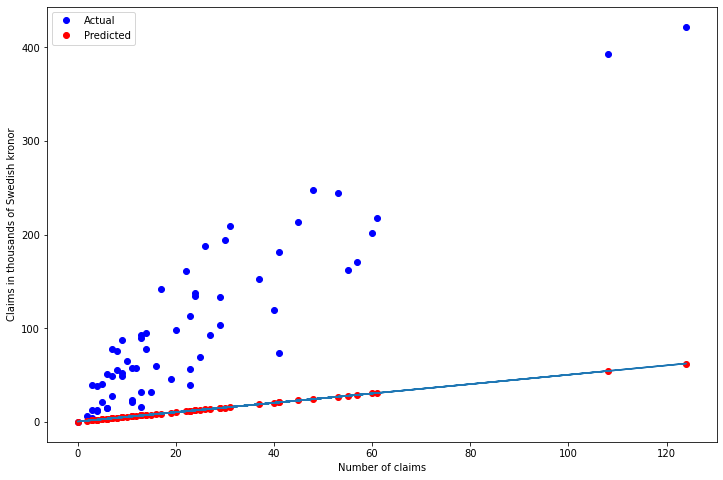

In [78]:
# Introduction to linear regression
def forward_pass(feature: jnp.ndarray, weight: jnp.ndarray, bias: jnp.ndarray) -> jnp.ndarray:
    return feature * weight + bias


# features is a MxN matrix, where M is the number of examples and N is the number of features
# In our case, N is 1, because we have only one feature
# M is the number of examples, which in our case is 63
# As a result our output is a 63x1 matrix
print(f"Our features has shape: {features.shape}")

# We know our model is a Linear Regression model, meaning we have F_w_b(x) = w * x + b where w, b are the model parameters and are a scalar value.
# and x is the model input, which is also a scalar value.
weight = jnp.array([0.5])
bias = jnp.array([0.5]) 
predictions = jnp.array([])
for feature in features:
    prediction = forward_pass(feature=feature, weight=weight, bias=bias)
    predictions = jnp.append(predictions, prediction)


# Lets plot the results
PlottingUtils.plot_results(features, labels, predictions)

That doesn't look too good... But that's still a bit vague. Let's try to make it a bit more unambiguous and for that, we need a cost function. 
A cost function is a summation over the loss function for all examples. What do we mean by that? 

Lets first define the loss function: 
$$
L(y^{pred}_i, y^{true}_i) = \frac{1}{2} * (y^{pred}_{i} - y^{true}_{i})^2
$$

The loss function determines how far "off" you are from the true value. The larger the loss is the further away you are from your target.
Now the $y^{true}_i$ is historical data that has already been collected (in our case the claims in thousands of Swedish Kronor)
Our prediction is what we need to compute, which we did during the forward pass. so, we can substitute that in our little formula below.


$$
\begin{align}
forward pass = y^{pred}_i \\
y^{pred}_i = f_{w,b}(x_i)  \\
f_{w,b}(x_i) = w * x_i + b \\
\end{align}
$$
$$
\begin{align}
L(y^{pred}_i, y^{true}_i) = \frac{1}{2} * (y^{pred}_{i} - y^{true}_{i})^2 \\
L(f_{w,b}(x_i), y^{true}_i) = \frac{1}{2} * (w * x_i + b - y^{true}_{i})^2 
\end{align}
$$

Alright. So the loss function is defined, but this is only for one feature, label pair (or more simple stated: one training example).
The next part has to do with the cost function often denoted as $J(w, b)$. What does this mean? For a given weight $w$ and bias $b$, calculate the loss function over all training examples.

$$

\frac{1}{m}\sum^{m - 1}_{i=0} * L(f_{w,b}(x_i), y^{true}_i) = \frac{1}{2m}\sum^{m - 1}_{i=0}(f_{w,b}(x_{i}) - y_i)^2
$$

notice how we moved the constant out of the equation. In addition that we substitute the quadratic term in the final part of the equation for the $L$.

Pfoeee.... With that out of the way, lets code!


In [79]:
def calculate_loss(predictions: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return 1 / 2 * (predictions - labels) ** 2

def calculate_cost(predictions: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return jnp.mean(calculate_loss(predictions, labels))

total_cost = calculate_cost(predictions=predictions, labels=jnp.array(labels))

print(f"The total cost is: {total_cost}")

The total cost is: 7537.8271484375


In [80]:
# wj_dw = xj * (yj - y_hatj)

In [81]:
# Gradient descent

def compute_gradient(features, weight, bias, labels):
    predictions = forward_pass(features, weight, bias)

    weight_derivative = jnp.mean(((predictions - labels) * features))  
    bias_derivative = jnp.mean((predictions - labels) * 1)
    return weight_derivative, bias_derivative

def update_weights(features, weight, bias, labels, learning_rate):
    weight_derivative, bias_derivative = compute_gradient(features, weight, bias, labels)
    weight = weight - learning_rate * weight_derivative
    bias = bias - learning_rate * bias_derivative
    return weight, bias

weight = 0
bias = 0
n_epochs = 1000
learning_rate = 0.0001
for i in range(n_epochs):
    predictions = forward_pass(features, weight, bias)
    cost = calculate_cost(predictions, labels)
    
    weight, bias = update_weights(features, weight, bias, labels, learning_rate)
    if i % 100 == 0:
        print(f"Epoch: {i} Cost: {cost}")

Epoch: 0 Cost: 8572.900390625
Epoch: 100 Cost: 724.6031494140625
Epoch: 200 Cost: 723.6050415039062
Epoch: 300 Cost: 722.6170654296875
Epoch: 400 Cost: 721.638916015625
Epoch: 500 Cost: 720.670654296875
Epoch: 600 Cost: 719.712158203125
Epoch: 700 Cost: 718.763427734375
Epoch: 800 Cost: 717.823974609375
Epoch: 900 Cost: 716.8941650390625


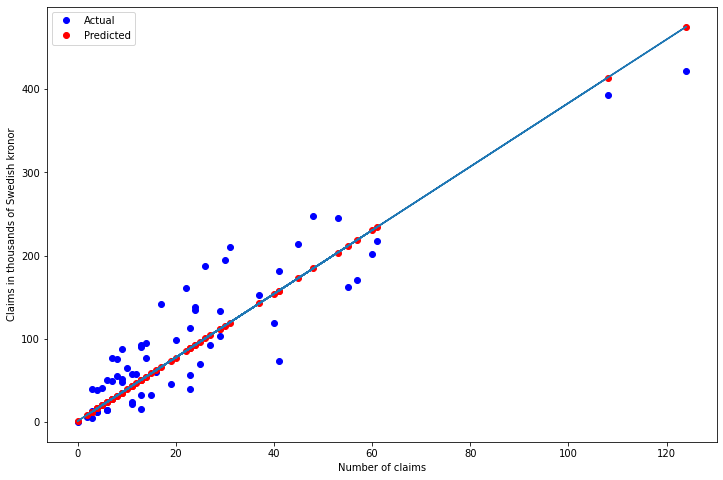

In [96]:
fig, ax = PlottingUtils.plot_results(
    features,
    labels,
    forward_pass(features, weight, bias)
)

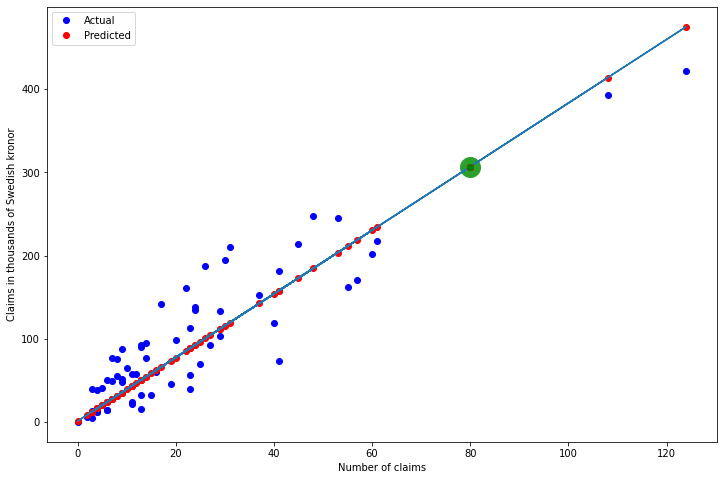

In [113]:
new_number_of_claims = jnp.array([80])
prediction = forward_pass(new_number_of_claims, weight, bias)
ax.scatter(new_number_of_claims, prediction, s=400)

display(fig)

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt